In [ ]:
#Install Packages if not installed : Py2neo is used for making connection between neo4j and python while afinn is used for the sentimental anaylsis
#!pip install py2neo
#!pip install afinn

In [4]:
#Importing the necessary libraries
from py2neo import *
from pandas import DataFrame
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from afinn import Afinn


# instantiating Neo4j driver instance
#twitter_troll_dataset = Graph("bolt://52.3.242.176:33673", auth=("neo4j","hush-nerve-stars"))
twitter_troll_dataset = Graph("bolt://54.85.153.239:35392", auth=("neo4j","inlets-hatchet-thursday"))

print("Stage 1.Graph Initiation")

twitter_troll_dataset.begin()


Stage 1.Graph Initiation


<b>EXPLORATORY DATA ANALYSIS<b>

In [5]:
#Total nodes present in the dataset
DataFrame(twitter_troll_dataset.run("MATCH (n) return count(n) AS All_nodes").data())

,All_nodes
0,281136


In [6]:
#Total edges/relationships present in the dataset
DataFrame(twitter_troll_dataset.run("Match ()-[r]->() return count(*) as Relationships").data())

,Relationships
0,493160


In [7]:
# To load all the label and its count present in the dataset
dataset_nodes=DataFrame(twitter_troll_dataset.run("match (n) return head(labels(n)) as Label, count(*) as Records").data())
dataset_nodes

,Label,Records
0,User,14273
1,Tweet,232061
2,Source,18
3,URL,21865
4,Hashtag,12919


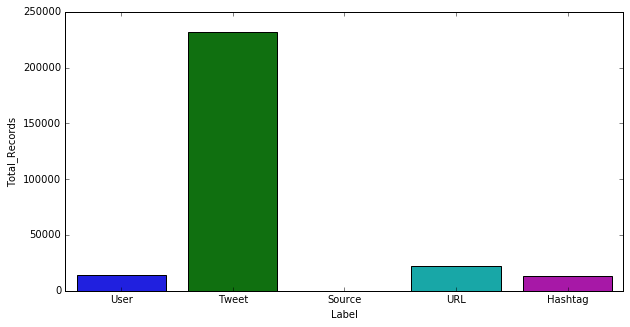

In [8]:
#Visualizing the Nodes and its total counts
import seaborn as sns
#t.plot.bar(x='Label',y='Records')
plt.figure(figsize=(10,5))
ax = sns.barplot(data=dataset_nodes, x= "Label", y = "Records")
ax.set(ylabel = 'Total_Records')
plt.show()

In [9]:
# To load all the relationships and its count present in the dataset
dataset_relationship=DataFrame(twitter_troll_dataset.run("Match ()-[r]->() return Type(r) as Relationship_Type, count(*) as Total_Count").data())
dataset_relationship

,Relationship_Type,Total_Count
0,MENTIONS,56110
1,POSTED,200833
2,RETWEETED,39649
3,IN_REPLY_TO,559
4,POSTED_VIA,58051
5,HAS_LINK,31166
6,HAS_TAG,106792


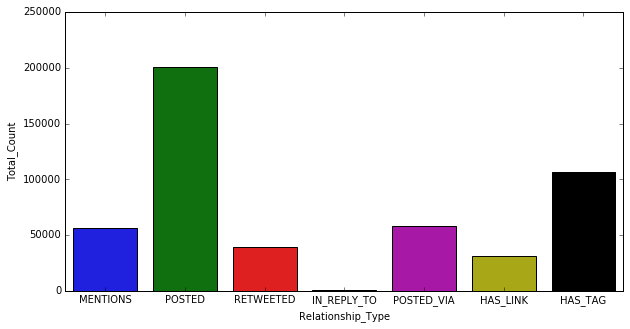

In [10]:
#Visualizing the Relationships and its total counts
import seaborn as sns
plt.figure(figsize=(10,5))
ax = sns.barplot(data=dataset_relationship, x= "Relationship_Type", y = "Total_Count")
#ax.set(ylabel = 'Total_Count')
plt.show()


In [11]:
#Number of users whose followers are more than 1000
DataFrame(twitter_troll_dataset.run("MATCH (u:User)-[r1:POSTED]->(t:Tweet) WHERE u.followers_count > 1000 WITH COUNT(t) AS count RETURN count").data())

,count
0,143206


In [12]:
#Top 5 users who posted tweets the most number of times
top_tweet_user=DataFrame(twitter_troll_dataset.run("MATCH (u:User)-[r1:POSTED]->(t:Tweet) WITH u, COUNT(t) AS Tweets_count RETURN Tweets_count,u.screen_name as Screen_name order by Tweets_count desc limit 5").data())
top_tweet_user

,Screen_name,Tweets_count
0,AmelieBaldwin,9262
1,hyddrox,6809
2,GiselleEvns,6582
3,PatriotBlake,4138
4,TheFoundingSon,3571


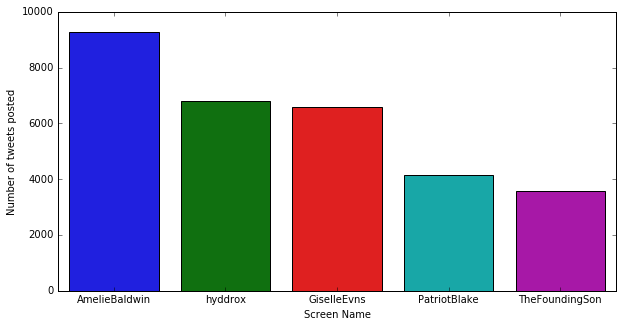

In [13]:
# selecting top 5 users who posted the most tweets
d = top_tweet_user.nlargest(columns="Tweets_count", n = 10) 
plt.figure(figsize=(10,5))
ax = sns.barplot(data=d, x= "Screen_name", y = "Tweets_count")
ax.set(xlabel='Screen Name',ylabel = 'Number of tweets posted')
plt.show()



In [14]:
#Top 5 users who posted tweets the most number of times with high follower count
DataFrame(twitter_troll_dataset.run("MATCH (u:User)-[:POSTED]->(t:Tweet) where u.followers_count>1000 WITH u,count(t) AS Tweets_count RETURN u.screen_name as Screen_name,Tweets_count ,u.followers_count as Followers order by Followers desc limit 5").data())

,Followers,Screen_name,Tweets_count
0,98412,MaxDementiev,5
1,94773,KadirovRussia,7
2,61609,Jenn_Abrams,726
3,60897,TodayNYCity,105
4,47080,LavrovMuesli,12


In [15]:
#Different hashtags used by top 10 people whose follower count is greater than 1000 and have used most number of hashtags
DataFrame(twitter_troll_dataset.run("MATCH (u:User)-[:POSTED]->(t:Tweet)-[:HAS_TAG]->(h:Hashtag) WHERE u.followers_count>1000 WITH u,count(distinct h) AS Hashtag_count,collect(distinct h.tag) AS Hashtag_names order by Hashtag_count desc limit 5 RETURN u.screen_name as Screen_name,Hashtag_count,Hashtag_names").data())

,Hashtag_count,Hashtag_names,Screen_name
0,1827,"[steinbaraka, libtards, birtherism, crookedhil...",AmelieBaldwin
1,1135,"[immigration, debate, clintonisthenewcword, ba...",hyddrox
2,916,"[fakenews, endchildabuse, az, crooked, thanks,...",PatriotBlake
3,675,"[p, m5s, boycott, trumppence16, maga, dobbs, a...",EmileeWaren
4,662,"[inhonorof, makeamericagreatagain, maniacsforc...",DorothieBell


In [16]:
# Influential Users who tweets are reposted or replied the most
DataFrame(twitter_troll_dataset.run("MATCH (u) - [] ->(t:Tweet)<-[:RETWEETED|IN_REPLY_TO]-(t1:Tweet)<-[:POSTED]-(u2:User) where u.screen_name is not null \
WITH DISTINCT(u.screen_name) as Screen_name,count(u2.screen_name) as Retweet_Users order by Retweet_Users desc RETURN Screen_name,Retweet_Users LIMIT 5").data())

,Retweet_Users,Screen_name
0,250,TEN_GOP
1,182,GiselleEvns
2,128,NotRitaHart
3,105,gloed_up
4,99,tpartynews


In [17]:
# Number of tweets on different dates
d=DataFrame(twitter_troll_dataset.run("MATCH (t:Tweet) WITH distinct left(t.created_str,10) AS date_str, count(t) AS number_of_tweets RETURN date_str,number_of_tweets ").data())

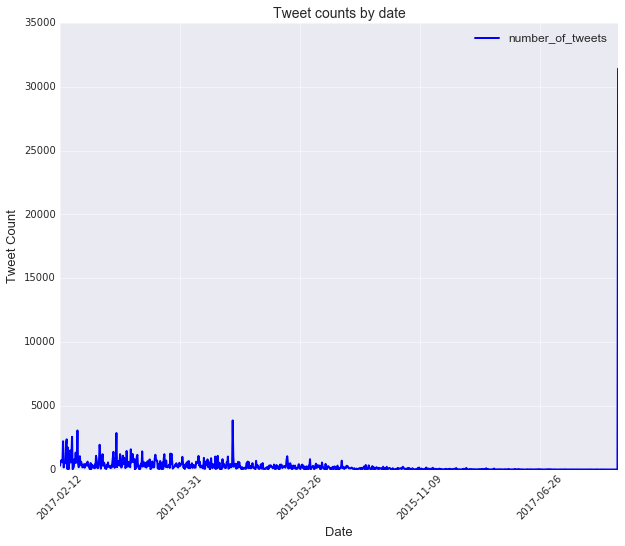

In [18]:
# number of tweets as per the date
plt.style.use('seaborn-darkgrid')
d.plot(x='date_str',y='number_of_tweets',linestyle = "-", figsize = (10,8), rot = 45, color = 'b',
                               linewidth = 2)
plt.title('Tweet counts by date', fontsize = 14)
plt.xlabel('Date', fontsize = 13)
plt.ylabel('Tweet Count', fontsize = 13)

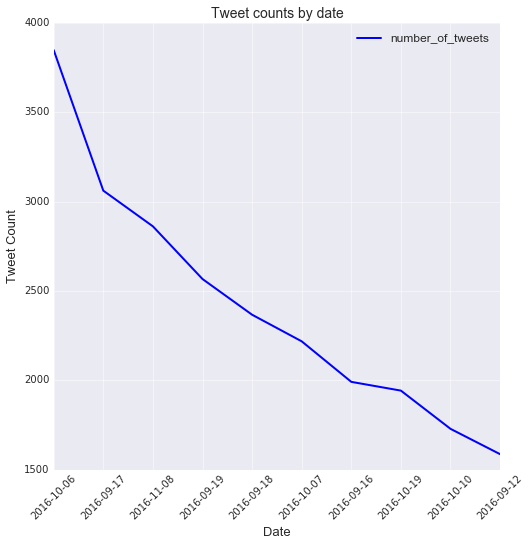

In [19]:
dates_order=DataFrame(twitter_troll_dataset.run("MATCH (t:Tweet) WITH distinct left(t.created_str,10) AS date_str, count(t) AS number_of_tweets where date_str is not null RETURN date_str,number_of_tweets order by number_of_tweets desc limit 10  ").data())
# number of tweets as per the dates
plt.style.use('seaborn-darkgrid')
dates_order.plot(x='date_str',y='number_of_tweets',linestyle = "-", figsize = (8,8), rot = 45, color = 'b',
                               linewidth = 2)
plt.title('Tweet counts by date', fontsize = 14)
plt.xlabel('Date', fontsize = 13)
plt.ylabel('Tweet Count', fontsize = 13)
plt.savefig('Date and tweet.png')

In [20]:
#Top Hashtags used
Hashtag_cloud=DataFrame(twitter_troll_dataset.run("MATCH (u)-[]->(h:Hashtag) \
WITH h.tag as Hashtag,count(h) AS total_count \
order by total_count desc \
RETURN Hashtag,total_count").data())

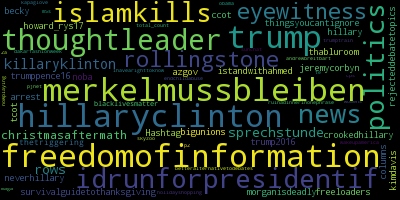

In [21]:
#Wordcloud of Top 10 Hashtags used : To analyse what people are talking about
WordCloud().generate(str(Hashtag_cloud)).to_image()

In [22]:
#The degree statistics on an average for a user : The people connected to one user on an average
DataFrame(twitter_troll_dataset.run("match (u:User) return avg(apoc.node.degree(u)) as Avg, max(apoc.node.degree(u)) as Max, min(apoc.node.degree(u)) as Min, stdev(apoc.node.degree(u)) as Stdv").data())

,Avg,Max,Min,Stdv
0,18.002032,9262,0,205.894677


<b> Data Analysis using Centrality Measures <b>

In [23]:
# Top 5 Users who should influnece i.e. on the basis of followers_count
DataFrame(twitter_troll_dataset.run("""MATCH (u:User) \
where u.followers_count is not null \
return u.screen_name as Screen_name ,u.followers_count as Followers_count order by Followers_count desc limit 5""").data())

,Followers_count,Screen_name
0,98412,MaxDementiev
1,94773,KadirovRussia
2,61609,Jenn_Abrams
3,60897,TodayNYCity
4,47080,LavrovMuesli


In [24]:
#Top 5 influential users on the basis of degree centrality called as out degree centrality:It includes the retweets /in_reply_to
DataFrame(twitter_troll_dataset.run("""MATCH (u: User) \
RETURN u.screen_name as Screen_name,u.id as Id, size ((u) - [] ->()<-[:RETWEETED|IN_REPLY_TO]-()) as Degree \
ORDER BY Degree DESC \
LIMIT 5""").data())

,Degree,Id,Screen_name
0,250,4224729994,TEN_GOP
1,182,2882013788,GiselleEvns
2,128,2496599688,NotRitaHart
3,105,3312143142,gloed_up
4,99,3990577513,tpartynews


In [25]:
#Find the other details of the user who is the most influential: 'TEN_GOP'
DataFrame(twitter_troll_dataset.run("""MATCH (u:User{screen_name:'TEN_GOP'}) RETURN u.description,u.id,u.location""").data())
# The TEN_GOP user is a fake user since no other details were found.

,u.description,u.id,u.location
0,,4224729994,


In [26]:
#Find the second most influential: 'GiselleEvns'
DataFrame(twitter_troll_dataset.run("""MATCH (u:User{screen_name:'GiselleEvns'}) RETURN u.description,u.id,u.location""").data())

,u.description,u.id,u.location
0,"if you don't work hard to achieve your dreams,...",2882013788,"Pittsburgh, US"


In [27]:
#Find the third most influential user: 'NotRitaHart'
DataFrame(twitter_troll_dataset.run("""MATCH (u:User{screen_name:'NotRitaHart'}) RETURN u.description,u.id,u.location""").data())

,u.description,u.id,u.location
0,Lost in the moment,2496599688,Atlanta


In [28]:
#To calculate the Page Rank Centrality on Users Network:To be continued
twitter_troll_dataset.run("""call algo.pageRank('MATCH (u:User) return id(u) as id',
'MATCH (u:User)-[:POSTED]->()<-[:RETWEETED|IN_REPLY_TO]-()<-[:POSTED]-(u2:User) return id(u) as source,id(u2) as target',
{graph:'cypher',writeProperty:'UserRank'});""").data()


[{u'computeMillis': 6,
  u'dampingFactor': 0.85,
  u'iterations': 20,
  u'loadMillis': 207,
  u'nodes': 14273,
  u'write': True,
  u'writeMillis': 31,
  u'writeProperty': u'UserRank'}]

In [29]:
#Continued
t=DataFrame(twitter_troll_dataset.run("""MATCH (u:User)
RETURN u.screen_name as Screen_name, u.UserRank
ORDER BY u.UserRank DESC LIMIT 5""").data())
t

,Screen_name,u.UserRank
0,GiselleEvns,5.652868
1,DorothieBell,2.877542
2,c__wells,2.631696
3,JeffreyKahunas,2.558382
4,hollandpatrickk,2.530974


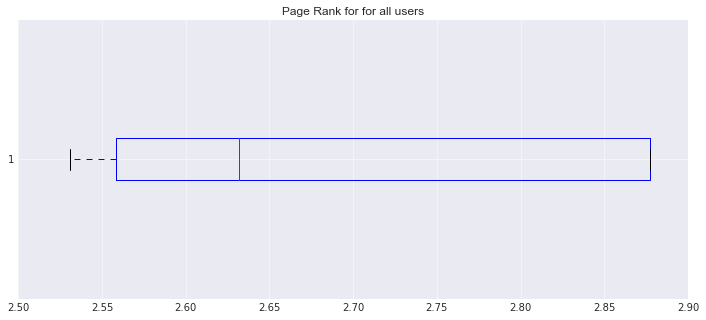

In [30]:
#Box plot for the users : To calculate the median, skewness and other statistics
plt.figure(figsize=(12,5))
plt.boxplot(t['u.UserRank'], showfliers=False, vert=False)
plt.title("Page Rank for for all users")
plt.show()

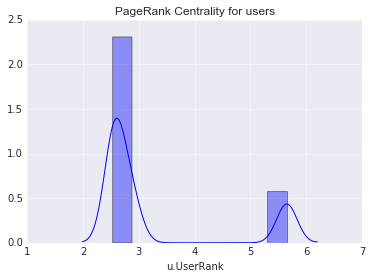

In [31]:
sns.distplot(t['u.UserRank'])
plt.title('PageRank Centrality for users')
plt.show()

In [32]:
#PageRank on a “mention” Network :Mention network cannot be considered as a good measure to get the list of influential users
twitter_troll_dataset.run("""call algo.pageRank('MATCH (u:User) return id(u) as id',
'MATCH (u:User)-[:POSTED]->()-[:MENTIONS]->(u2:User) return id(u) as source,id(u2) as target',
{graph:'cypher',writeProperty:'mentionRank'});""").data()

[{u'computeMillis': 79,
  u'dampingFactor': 0.85,
  u'iterations': 20,
  u'loadMillis': 185,
  u'nodes': 14273,
  u'write': True,
  u'writeMillis': 29,
  u'writeProperty': u'mentionRank'}]

In [33]:
DataFrame(twitter_troll_dataset.run("""MATCH (u:User)
RETURN u.name, u.screen_name, u.mentionRank, u.UserRank
ORDER BY u.mentionRank desc LIMIT 20""").data())

,u.UserRank,u.mentionRank,u.name,u.screen_name
0,0.150000,3.874117,None,None
1,0.150000,2.104972,None,None
2,0.150000,1.485917,None,None
3,0.150000,1.334957,None,None
4,0.150000,1.298425,None,None
5,0.967054,0.967054,Darrell Hunt,Darrell_H_Hunt
6,0.150000,0.959979,None,None
7,0.150000,0.821459,None,None
8,0.967055,0.551917,Warfare Worldwide,WarfareWW
9,0.150000,0.534074,None,None


In [34]:
#Betweenness Centrality
twitter_troll_dataset.run("""call algo.betweenness('MATCH (u:User) return id(u) as id',
'MATCH (u:User)-[:POSTED]->()<-[:RETWEETED|IN_REPLY_TO]-()<-[:POSTED]-(u2:User) return id(u) as source,id(u2) as target',
{graph:'cypher',writeProperty:'Userbetweenness'});""").data()

[{u'computeMillis': 247,
  u'loadMillis': 217,
  u'maxCentrality': -1.0,
  u'minCentrality': -1.0,
  u'nodes': 14273,
  u'sumCentrality': -1.0,
  u'writeMillis': 29}]

In [35]:
DataFrame(twitter_troll_dataset.run("""MATCH (u:User)
RETURN u.screen_name as Screen_name, u.Userbetweenness
ORDER BY u.Userbetweenness desc LIMIT 5""").data())

,Screen_name,u.Userbetweenness
0,JeanneMccarthy0,2825.479751
1,GiselleEvns,2590.016867
2,CassieWeltch,1006.438058
3,MelvinSRoberts,823.768866
4,DaileyJadon,806.972224


In [36]:
twitter_troll_dataset.run("""call algo.closeness('MATCH (u:User) return id(u) as id',
'MATCH (u:User)-[:POSTED]->()<-[:RETWEETED|IN_REPLY_TO]-()<-[:POSTED]-(u2:User) return id(u) as source,id(u2) as target',
{graph:'cypher',writeProperty:'Usercloseness'});""").data()

[{u'computeMillis': 20,
  u'loadMillis': 194,
  u'nodes': 14273,
  u'writeMillis': 27}]

In [37]:
#Closeness Centrality
DataFrame(twitter_troll_dataset.run("""MATCH (u:User)
RETURN u.screen_name as Screen_name, u.Usercloseness
ORDER BY u.Usercloseness desc LIMIT 5""").data())

,Screen_name,u.Usercloseness
0,Jenn_Abrams,79.000000
1,gloed_up,20.000000
2,BleepThePolice,13.333333
3,TrayneshaCole,13.333333
4,tpartynews,10.700000


In [38]:
#Eigen Centrality
twitter_troll_dataset.run("""call algo.eigenvector('MATCH (u:User) return id(u) as id',
'MATCH (u:User)-[:POSTED]->()<-[:RETWEETED|IN_REPLY_TO]-()<-[:POSTED]-(u2:User) return id(u) as source,id(u2) as target',
{graph:'cypher',writeProperty:'eigenvector'});""").data()


[{u'computeMillis': 7,
  u'dampingFactor': 1.0,
  u'iterations': 20,
  u'loadMillis': 223,
  u'nodes': 14273,
  u'write': True,
  u'writeMillis': 30,
  u'writeProperty': u'eigenvector'}]

In [39]:
DataFrame(twitter_troll_dataset.run("""MATCH (u:User)
RETURN u.name, u.screen_name, u.eigenvector,u.UserRank
ORDER BY u.eigenvector desc LIMIT 10""").data())

,u.UserRank,u.eigenvector,u.name,u.screen_name
0,5.652868,1539.662131,Giselle Evans,GiselleEvns
1,2.530552,712.766092,Fluffy Melvin,MelvinSRoberts
2,1.976709,375.421908,David Collier,pureDavie
3,0.830310,137.020342,World Of Hashtags,WorldOfHashtags
4,1.084580,132.276469,Tracy Brooks,traceyhappymom
5,1.222317,130.490261,Jadon Dailey,DaileyJadon
6,1.073389,116.512504,Kathie,KathieMrr
7,1.031575,116.330877,Rita Hart,NotRitaHart
8,1.062163,115.497493,Jacky,queenofthewo
9,1.170692,103.678256,Cassie Weltch,CassieWeltch


In [40]:
#Eigen Centrality with normalization
twitter_troll_dataset.run("""call algo.eigenvector('MATCH (u:User) return id(u) as id',
'MATCH (u:User)-[:POSTED]->()<-[:RETWEETED|IN_REPLY_TO]-()<-[:POSTED]-(u2:User) return id(u) as source,id(u2) as target',
{normalization: "max",graph:'cypher',writeProperty:'eigenvector2'});""").data()

[{u'computeMillis': 6,
  u'dampingFactor': 1.0,
  u'iterations': 20,
  u'loadMillis': 212,
  u'nodes': 14273,
  u'write': True,
  u'writeMillis': 24,
  u'writeProperty': u'eigenvector2'}]

In [41]:
DataFrame(twitter_troll_dataset.run("""MATCH (u:User)
RETURN u.name, u.screen_name, u.eigenvector2,u.UserRank
ORDER BY u.eigenvector2 desc LIMIT 10""").data())

,u.UserRank,u.eigenvector2,u.name,u.screen_name
0,5.652868,1.000000,Giselle Evans,GiselleEvns
1,2.530552,0.462937,Fluffy Melvin,MelvinSRoberts
2,1.976709,0.243834,David Collier,pureDavie
3,0.830310,0.088994,World Of Hashtags,WorldOfHashtags
4,1.084580,0.085913,Tracy Brooks,traceyhappymom
5,1.222317,0.084753,Jadon Dailey,DaileyJadon
6,1.073389,0.075674,Kathie,KathieMrr
7,1.031575,0.075556,Rita Hart,NotRitaHart
8,1.062163,0.075015,Jacky,queenofthewo
9,1.170692,0.067338,Cassie Weltch,CassieWeltch


In [42]:
#Community Detection : The users who are present in the same community
twitter_troll_dataset.run("""call algo.unionFind('MATCH (u:User) RETURN id(u) as id',
'MATCH (u:User)-[:POSTED]->()<-[:RETWEETED|IN_REPLY_TO]-()<-[:POSTED]-(u2:User) RETURN id(u) as source,id(u2) as target',
{graph:'cypher',partitionProperty: "community"})""").data()

[{u'communityCount': 14129,
  u'computeMillis': 14,
  u'loadMillis': 198,
  u'nodes': 14273,
  u'p1': 1,
  u'p10': 1,
  u'p100': 141,
  u'p25': 1,
  u'p5': 1,
  u'p50': 1,
  u'p75': 1,
  u'p90': 1,
  u'p95': 1,
  u'p99': 1,
  u'partitionProperty': u'community',
  u'postProcessingMillis': 1,
  u'setCount': 14129,
  u'write': True,
  u'writeMillis': 25,
  u'writeProperty': u'community'}]

In [43]:
#To check the nodes and the total nodes present in a union algo community
DataFrame(twitter_troll_dataset.run("""MATCH (u:User)
WITH u.community as community,collect(u.screen_name) as nodes_in_community,count(*) as count_nodes
RETURN community,nodes_in_community[..10],count_nodes ORDER BY count_nodes DESC
LIMIT 10""").data())

,community,count_nodes,nodes_in_community[..10]
0,20,141,"[NoJonathonNo, CharlesJHarper, PrettyLaraPlace..."
1,342,3,"[russilanrogov, LavrovMuesli, WhiteHouseCards]"
2,0,2,"[SCOTTGOHARD, Siccerthanyou]"
3,346,2,"[erdollum, berkhoff85]"
4,5,1,[darknally]
5,6,1,[lagonehoe]
6,2,1,[skatewake1994]
7,4,1,[MargoSavazh]
8,8,1,[MrMoraan]
9,7,1,[YouJustCtrlC]


In [44]:
#Label Propogation community Detection
twitter_troll_dataset.run("""call algo.labelPropagation('MATCH (u:User) return id(u) as id',
'MATCH (u:User)-[:POSTED]->()<-[:RETWEETED|IN_REPLY_TO]-()<-[:POSTED]-(u2:User) return id(u) as source,id(u2) as target','Outgoing',
{graph:'cypher',partitionProperty: "label"});
""").data()

[{u'communityCount': 14193,
  u'computeMillis': 10,
  u'didConverge': False,
  u'iterations': 1,
  u'loadMillis': 519,
  u'nodes': 14273,
  u'p1': 1,
  u'p10': 1,
  u'p100': 27,
  u'p25': 1,
  u'p5': 1,
  u'p50': 1,
  u'p75': 1,
  u'p90': 1,
  u'p95': 1,
  u'p99': 1,
  u'partitionProperty': u'label',
  u'postProcessingMillis': 26,
  u'weightProperty': u'weight',
  u'write': True,
  u'writeMillis': 1,
  u'writeProperty': u'label'}]

In [45]:
#To check the nodes and the total nodes present in a community using label propgation
DataFrame(twitter_troll_dataset.run("""MATCH (u:User)
RETURN u.label as community,collect(u.screen_name) as nodes_in_community,count(*) as count_nodes ORDER BY count_nodes DESC
LIMIT 10""").data())

,community,count_nodes,nodes_in_community
0,17,27,"[JeffreyKahunas, CarrieThornthon, WesternWindW..."
1,188,20,"[IlikeBIGbuttand, DaileyJadon, Gab1Aldana, Mel..."
2,90,7,"[mrclydepratt, PaolaKinck, happkendrahappy, bl..."
3,44,5,"[TEN_GOP, tpartynews, rightnpr, RealTEN_GOP, M..."
4,91,5,"[hyddrox, DorothieBell, Stanley_Cox_, SouthLon..."
5,207,5,"[Adrienne_GG, CurtisBigMan, dannythehappies, h..."
6,228,4,"[cassishere, JeanneMccarthy0, Kelvin_Chambers,..."
7,61,3,"[ArchieOlivers, LazyKStafford, Danny_Turner_1]"
8,89,3,"[CharlesJHarper, HellieEdwards, DonnieLMiller]"
9,206,3,"[BleepThePolice, gloed_up, TrayneshaCole]"


In [46]:
#Added a new_label called union_Group for a close clustering community
twitter_troll_dataset.run("""match (u:User)
with u order by u.pagerank desc
with u.community as union_region, count(*) as num, collect(u) as users,head(collect(u.screen_name)) as regionName order by num desc
limit 50
foreach (u in users | 
     set u:UnionCommunity set u.regionName = regionName)""").data()

[]

In [47]:
#Added a community called labelpropogation based on the label propogation method for finding close clustering nodes in a community
twitter_troll_dataset.run("""match (u:User)
with u order by u.pagerank desc
with u.label as label_region, count(*) as num, collect(u) as users,head(collect(u.screen_name)) as regionName order by num desc
limit 50
foreach (u in users | 
     set u:labelPropogationCommunity set u.regionName = regionName)""").data()

[]

In [48]:
#Collecting dataset which is important for the community 20 and storing it in a dataset_hashtags
dataset_hashtags=DataFrame(twitter_troll_dataset.run("""MATCH (u:User{community:20})-[:POSTED]->(t:Tweet)-[:HAS_TAG]->(h:Hashtag)
return distinct(u.screen_name) as screen_name,t.id as Tweet_ID,t.text as Tweet_Text,collect(h.tag) as Hashtag""").data())
dataset_hashtags.head()

,Hashtag,Tweet_ID,Tweet_Text,screen_name
0,"[p2, tcot]",785763510802259969,RT @ZaibatsuNews: Trump's Extremist Bigotry Ag...,NoJonathonNo
1,[rnc],762218612656631808,RT @StopMassIncNet: Defend flag burners at #RN...,NoJonathonNo
2,"[maga, pjnet, ccot, tcot]",784296955379785728,RT @ZaibatsuNews: Trump adult film cameo unear...,NoJonathonNo
3,"[blacklivesmatter, mississippi, blm, trump]",794035904256020480,RT @RDCresearcher: 'Vote #Trump' painted on bl...,NoJonathonNo
4,"[pjnet, maga, ccot, tcot]",796862352331337729,RT @ZaibatsuNews: Trump adult film cameo unear...,NoJonathonNo


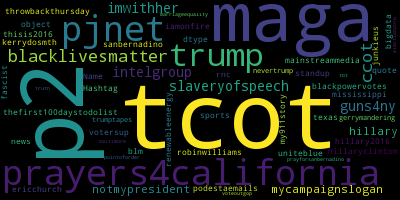

In [49]:
#Extracted data of a community and making a wordcloud to understand what people are thinking of the same community
WordCloud().generate(str(dataset_hashtags['Hashtag'])).to_image()

In [50]:
#SENTIMENT ANALYSIS
#Extracted description text of community which contains most influential people and extracted sentiments via text and analysed it later 
#cHECKING IF ANY NULL VALUES PRESENT and the type of dataset
print(dataset_hashtags.shape)
print(dataset_hashtags.dtypes)
dataset_hashtags.isnull().sum().sort_values(ascending = False)
dataset_hashtags['Tweet_Text'].head(10)

(73390, 4)
Hashtag        object
Tweet_ID       object
Tweet_Text     object
screen_name    object
dtype: object


0    RT @ZaibatsuNews: Trump's Extremist Bigotry Ag...
1    RT @StopMassIncNet: Defend flag burners at #RN...
2    RT @ZaibatsuNews: Trump adult film cameo unear...
3    RT @RDCresearcher: 'Vote #Trump' painted on bl...
4    RT @ZaibatsuNews: Trump adult film cameo unear...
5    RT @ZaibatsuNews: In Disastrous Interview, Mik...
6    RT @Petergrand: Is that the land I'm beginning...
7    RT @realGeorgeTorr: @ananavarro rips another #...
8    RT @ZaibatsuNews: Trump campaign confessed to ...
9    RT @ProgPoli: #HillaryClinton will win the pop...
Name: Tweet_Text, dtype: object

In [51]:
#DATA PREPROCESSING
dataset_hashtags['Tweet_Text']=dataset_hashtags['Tweet_Text'].str.lower()
dataset_hashtags['Tweet_Text']=dataset_hashtags['Tweet_Text'].str.replace("^rt.*?:", " ")


In [52]:
#DATA PREPROCESSING : Continued
#Removing hashtags
dataset_hashtags['Tweet_Text']=dataset_hashtags['Tweet_Text'].str.replace("(#[^#\s]+)",'')
#Removing Links
dataset_hashtags['Tweet_Text']=dataset_hashtags['Tweet_Text'].str.replace("(https://[^\s]+)",'')
#Removing characters other than alphabets
dataset_hashtags['Tweet_Text']=dataset_hashtags['Tweet_Text'].str.replace("[^a-zA-Z]", " ")


In [53]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)
dataset_hashtags.head()

,Hashtag,Tweet_ID,Tweet_Text,screen_name
0,"[p2, tcot]",785763510802259969,trump s extremist bigotry against muslims is now the moderate gop position,NoJonathonNo
1,[rnc],762218612656631808,defend flag burners at demand the charges be dropped donate to cover court costs https,NoJonathonNo
2,"[maga, pjnet, ccot, tcot]",784296955379785728,trump adult film cameo unearthed by buzzfeed,NoJonathonNo
3,"[blacklivesmatter, mississippi, blm, trump]",794035904256020480,vote painted on black church set ablaze in,NoJonathonNo
4,"[pjnet, maga, ccot, tcot]",796862352331337729,trump adult film cameo unearthed by buzzfeed,NoJonathonNo


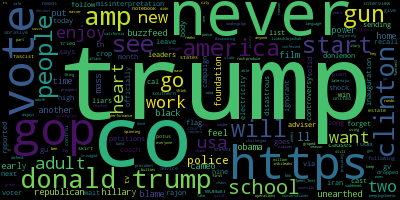

In [54]:
#Wordcloud of Tweet_Text
WordCloud().generate(str(dataset_hashtags['Tweet_Text'])).to_image()

In [55]:
afinn = Afinn(emoticons=True)

In [56]:
#The text analysis tells us the people are talking negatively of the elections and is against donald trump.
#The negative score tells us about people behaviour. Also, the sentiments of each user could be analysed which helped me to understand the python package working
afinn_scores=afinn.score(str(dataset_hashtags.Tweet_Text))
afinn_scores

-63.0

In [57]:
afinn_scores = [afinn.score(Tweet_Text) for Tweet_Text in dataset_hashtags.Tweet_Text]

In [58]:
dataset_hashtags['afinn']=afinn_scores

In [59]:
#afinn represents the sentiment score, sentiment is the positive or negative emotions and the text on which it applies.
for i in dataset_hashtags['afinn']:
    if (i==0):
        dataset_hashtags['sentiment']= 'Neutral'

    elif (i>0):
        dataset_hashtags['sentiment']='Positive'

    elif (i<0):
        dataset_hashtags['sentiment']='Negative'

In [62]:
dataset_hashtags[['sentiment','afinn','Tweet_Text']].head(10)

,sentiment,afinn,Tweet_Text
0,Negative,-2.0,trump s extremist bigotry against muslims is now the moderate gop position
1,Negative,-2.0,defend flag burners at demand the charges be dropped donate to cover court costs https
2,Negative,0.0,trump adult film cameo unearthed by buzzfeed
3,Negative,0.0,vote painted on black church set ablaze in
4,Negative,0.0,trump adult film cameo unearthed by buzzfeed
5,Negative,-4.0,in disastrous interview mike pence flees from his own running mate donald trump https
6,Negative,0.0,is that the land i m beginning to feel slide of gop
7,Negative,0.0,ananavarro rips another lapdog donlemon cnn
8,Negative,0.0,trump campaign confessed to three major voter suppression operations https
9,Negative,7.0,will win the popular vote by more than million the electoral college needs to go
